<a href="https://colab.research.google.com/github/thijsgelton/P9-Group7_VariationalAutoEncoder/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

```
SOW-MKI95 Computer Graphics & Computer Vision Spring
Variational autoencoders practical
```

```
Group number: 7
Student 1 name/number: Marit Hagens, s4808061
Student 2 name/number: Joost Verhaert, s1047220
Student 3 name/number: Thijs Gelton, s4480783
```


#1. Install MXnet GPU and import libraries

In [3]:
!pip install mxnet-cu100

     |████████████████████████████████| 352.6MB 51kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [4]:
from mxnet import nd, gluon
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.contrib.estimator import estimator
from mxnet.gluon.contrib.estimator.event_handler import TrainBegin, TrainEnd, EpochEnd, CheckpointHandler

import matplotlib.pyplot as plt
import mxnet as mx
import numpy as np
import math
from tqdm.notebook import tqdm

%matplotlib inline

# Feel free to import other modules/packages

## 1.1 Set device context to gpu.

In [5]:
def gpu_device(gpu_number=0):
    try:
        _ = mx.nd.array([1, 2, 3], ctx=mx.gpu(gpu_number))
    except mx.MXNetError:
        return None
    return mx.gpu(gpu_number)

gpu = gpu_device()

if gpu:
    print('Using GPU for model_ctx')
    model_ctx = gpu
else:
    print('Using CPU for model_ctx')
    model_ctx = mx.cpu()

Using GPU for model_ctx


#2. Loading in the MNIST dataset.

In [24]:
# Fixing the random seed
mx.random.seed(42)

# Get data
mnist = mx.test_utils.get_mnist()

In [25]:
# Create data iterators
batch_size = 32
train_data = mx.io.NDArrayIter(mnist['train_data'].reshape(-1, 784), mnist['train_label'], batch_size, shuffle=True)
val_data = mx.io.NDArrayIter(mnist['test_data'].reshape(-1, 784), mnist['test_label'], batch_size)

#3. Develop the Variational Auto-Encoder model

### Task 1 (10 points):

* Implement the decoder class for a variational autoencoder.

---o---

Recall that the decoder transforms latents (features) to observables (images). It corresponds to p(x | z) in the context of variational inference (and the slides), where x is observables and z is latents. Note that it should output the Gaussian parameters (mean and variance per pixel) of images rather than images themselves.

---o---

In [26]:
class Decoder(nn.HybridSequential):
    def __init__(self, activation = "relu", hiddens = 400, observables = 784, layers = 1, **kwargs): # Feel free to use different arguments
        super(Decoder, self).__init__(**kwargs)
        for i in range(layers):
            self.add(nn.Dense(hiddens, activation=activation))
        self.add(nn.Dense(observables, activation="sigmoid"))       
        

### Task 2 (10 points):

* Implement the encoder class for a variational autoencoder.

---o---

Recall that the encoder transforms observables (images) to latents (features). It corresponds to q(z | x) in the context of variational inference (and the slides), where z is latents and x is observables. Note that it should output the Gaussian parameters (mean and variance per feature) of features rather than features themselves.

---o---

In [27]:
class Encoder(nn.HybridSequential):
    def __init__(self, activation = "relu", hiddens= 400, latents = 2, layers = 1, **kwargs): # Feel free to use different arguments
        super(Encoder, self).__init__(**kwargs)
        for i in range(layers):
            self.add(nn.Dense(hiddens, activation=activation))
        self.add(nn.Dense(latents * 2)) # No activation function, because mean and std can be [-inf, +inf]

### Task:

* Implement the loss function class for a variational autoecoder.

---o---

The loss function takes the following arguments as input:

* x        : input images (mini batch)
* x_mean   : mean of the decoded images (output of the decoder)
* x_log_var: mean of the decoded images (output of the decoder)
* z_mean   : mean of the encoded features (output of the encoder)
* z_log_var: log variance of the encoded features (output of the encoder)

It gives the following evidence lower bound (ELBO) as ouput:

* $L = D_{KL}(q(z | x), p(z)) -  E_{z\sim q}[log p(x | z)]$

where

* The first term is the KL divergence between the approximate Gaussian posterior (q) and the standard Gaussian prior (p), which can be interpreted as a form of regularization.
* The second term is the Gaussian negative log likelihood, which is the term that fits the data and is very similar to the usual loss functions that are usded in deep learning.

---o---

In [28]:
class Lossfun:
    def __init__(self, w = 0.5): # Feel free to use different w which can be used as the weight of the different loss components
        self.w = w

    def __call__(self, x, x_hat, z_mean, z_log_var):
        return (1 - self.w) * self.get_nll(x, x_hat) - self.w * self.get_kl(z_mean, z_log_var)

    def get_kl(self, z_mean, z_log_var):
        return nd.mean(1 + z_log_var - nd.square(z_mean) - nd.exp(z_log_var))

    def get_nll(self, x, x_hat):        
        return -nd.mean(x * nd.log(x_hat + 1e-10) + (1-x) * nd.log(1 - x_hat + 1e-10))

### Task (5 points):

* Implement the variational autoencoder.

In [29]:
class VariationalAutoencoder(gluon.HybridBlock):
    def __init__(self,  activation = "relu", hiddens= 400, latents = 2, observables = 784, layers = 1, **kwargs): # Feel free to use different arguments
        super(VariationalAutoencoder, self).__init__()
        self.latents = latents
        with self.name_scope():
            self.encoder = Encoder(activation, hiddens, latents, layers, **kwargs)
            self.decoder = Decoder(activation, hiddens, observables, layers, **kwargs)

    def hybrid_forward(self, F, x):
        mean_lv = self.encoder(x)        
        z_mean, z_log_var = F.split(mean_lv, axis=1, num_outputs=2)
        eps = F.random_normal(loc=0, scale=1, shape=(x.shape[0], self.latents), ctx=model_ctx) # Reparamitisation trick
        z = z_mean + F.exp(0.5 * z_log_var) * eps
        x_hat = self.decoder(z)
        return x, x_hat, z_mean, z_log_var

### Task (25 points):

* Train the variational autoencoder on the Mnist dataset. You can refer to the previous assignment to implement your training loop.

In [30]:
# check wheter there is a gpu and use the best option
gpus = mx.test_utils.list_gpus()
ctx =  [mx.gpu()] if gpus else [mx.cpu(0), mx.cpu(1)]
vae_model = VariationalAutoencoder()
loss_fn = Lossfun()
vae_model.initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)
trainer = gluon.Trainer(vae_model.collect_params(), 'adam', {'learning_rate': 0.02})

In [31]:
# loss_fn(*vae_model(next(train_data).data[0].as_in_context(model_ctx)))

In [32]:
import time
n_epoch = 20
print_period = n_epoch // 10
start = time.time()

training_loss = []
validation_loss = []

for i in tqdm(range(n_epoch), desc='epochs'):
    # Reset the train data iterator.
    epoch_loss = 0
    epoch_val_loss = 0

    train_data.reset()
    val_data.reset()

    n_batch_train = 0
    # Loop over the train data iterator.
    for batch in train_data:
        n_batch_train +=1
        # Splits train data into multiple slices along batch_axis
        # and copy each slice into a context.
        data = batch.data[0].as_in_context(model_ctx)
        # Splits train labels into multiple slices along batch_axis
        # and copy each slice into a context.
        # label = gluon.utils.split_and_load(batch.label[0], ctx_list=ctx, batch_axis=0)
        outputs = []
        # Inside training scope
        with ag.record():
            z = vae_model(data)
            # Computes softmax cross entropy loss.
            loss = loss_fn(*z)
        loss.backward()
        trainer.step(batch.data[0].shape[0])
        epoch_loss += nd.mean(loss).asscalar()

        # Backpropagate the error for one iteration.
        outputs.append(z)

    n_batch_val = 0
    for batch in val_data:
        n_batch_val +=1
        data = batch.data[0].as_in_context(model_ctx)
        z = vae_model(data)
        loss = loss_fn(*z)
        epoch_val_loss += nd.mean(loss).asscalar()

    epoch_loss /= n_batch_train
    epoch_val_loss /= n_batch_val

    training_loss.append(epoch_loss)
    validation_loss.append(epoch_val_loss)

    if i % max(print_period,1) == 0:
        tqdm.write('Epoch{}, Training loss {}, Validation loss {}'.format(i, epoch_loss, epoch_val_loss))

end = time.time()
print('Time elapsed: {:.2f}s'.format(end - start))

Epoch0, Training loss 0.21915037452379862, Validation loss 0.13157668507422882
Epoch2, Training loss 0.13161075510581335, Validation loss 0.1314338180013358
Epoch4, Training loss 0.13154232259988785, Validation loss 0.13136736332132412
Epoch6, Training loss 0.13151275641123453, Validation loss 0.13133086623570409
Epoch8, Training loss 0.13148787577549617, Validation loss 0.13133086195102514
Epoch10, Training loss 0.13148297608296075, Validation loss 0.1313869628710107
Epoch12, Training loss 0.13148567999601365, Validation loss 0.13130095420173182
Epoch14, Training loss 0.13148287873665493, Validation loss 0.1313169352924481
Epoch16, Training loss 0.13148050408760706, Validation loss 0.13137392659252062
Epoch18, Training loss 0.1314816415866216, Validation loss 0.13132935257765432

Time elapsed: 231.77s


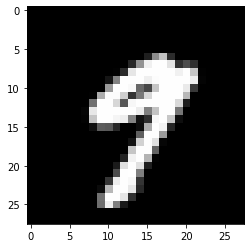

In [47]:
test_img = mnist["test_data"][20, 0]
plt.imshow(test_img, cmap='gray')

In [48]:
x, x_hat, z_mean, z_log_var = vae_model(nd.array(test_img.reshape(1, 784)).as_in_context(model_ctx))

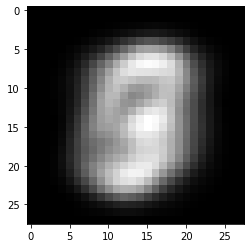

In [49]:
plt.imshow(x_hat[0].asnumpy().reshape(28, 28), cmap='gray')

### Task (50 points):
* Evaluate the reconstruction quality of the variational autoencoder: Draw some Mnist like images, encode them, decode them, visualize them and briefly explain the results.
 * Repeat the task with drawings of something else (e.g., a face).
* Evaluate the sampling quality of the variational autoencoder: Sample some random features from the prior, decode them, visualize them and briefly explain the results.
 * Repeat the task with features on a regular grid.
* Evaluate the latent quality of the variational autoencoder: Scatter plot features of images, color code their labels.

In [ ]:
# Your code here...